## MNIST autoencoder, focussing on the number of neurons in the dense layer

## Setup

In [2]:
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Input, Conv2D, MaxPooling2D, Conv2DTranspose, Reshape, concatenate 
from tensorflow.keras import utils, losses, optimizers, callbacks, regularizers
import numpy as np
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from tensorflow import reduce_sum, abs as tf_abs, add as tf_add
%matplotlib notebook

/usr/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/usr/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


### Load data, normalise, set to 0 or 1 (for logistic regression)

In [3]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train / 255.0
x_test = x_test / 255.0

x_train = np.expand_dims(x_train, 3)
x_test = np.expand_dims(x_test, 3)

x_train[x_train>=0.5] = 1.0
x_train[x_train<0.5] = 0

x_test[x_test>=0.5] = 1.0
x_test[x_test<0.5] = 0

x_val = x_train[50000:, :, :, :]
y_val = y_train[50000:]
x_train = x_train[:50000, :, :, :]
y_train = y_train[:50000]

# One hot, in case we need it later
num_classes = 10
y_train_onehot = utils.to_categorical(y_train, num_classes)
y_val_onehot = utils.to_categorical(y_val, num_classes)
y_test_onehot = utils.to_categorical(y_val, num_classes)

data_shape = x_train.shape[1:]

In [4]:
ones = np.sum(x_train==1)
zeros = np.sum(x_train==0)
frac = ones / (zeros + ones)
one_weighting = 1.0 / frac
print(one_weighting)

7.543624569200343


### Create model, with varying numbers of dense nodes

In [29]:
def model_n(data, n_dense_nodes, dropout_amount):
    
    # DOWN bloc 1
    c1 = Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same', 
                     name='Conv_1', kernel_regularizer=regularizers.l2(0.01))(data)
    c2 = Conv2D(32, (3, 3), activation='relu', name='Conv_2', padding='same', 
                     kernel_regularizer=regularizers.l2(0.01))(c1)
    p2 = MaxPooling2D(pool_size=(2, 2), name='Pool_2')(c2)
    d2 = Dropout(dropout_amount, name='Dropout_2')(p2)
    
    # DOWN bloc 2
    c3 = Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same', 
                     name='Conv_3', kernel_regularizer=regularizers.l2(0.01))(d2)
    c4 = Conv2D(32, (3, 3), activation='relu', name='Conv_4', padding='same', 
                     kernel_regularizer=regularizers.l2(0.01))(c3)
    p4 = MaxPooling2D(pool_size=(2, 2), name='Pool_4')(c4)
    d4 = Dropout(dropout_amount, name='Dropout_4')(p4)
    
    # DOWN bloc 3
    c5 = Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same', 
                     name='Conv_5', kernel_regularizer=regularizers.l2(0.01))(d4)
    c6 = Conv2D(32, (3, 3), activation='relu', name='Conv_6', padding='same', 
                     kernel_regularizer=regularizers.l2(0.01))(c5)
    d6 = Dropout(dropout_amount, name='Dropout_6')(c6)
    
    # Dense layer at bottom
    f7 = Flatten(name='Flatten_7')(d6)
    dense7 = Dense(n_dense_nodes, activation='relu', name='Dense_7', 
                  bias_regularizer=regularizers.l1(0.0001), 
                  activity_regularizer=regularizers.l1(0.00001))(f7)
    dense8 = Dense(784, activation='relu', name='Dense_8')(dense7)
    reshape8 = Reshape((7, 7, 16), name='Reshape_8')(dense8)
    
    # Upward bloc one
    c10 = Conv2D(16, kernel_size=(3, 3), activation='relu', padding='same', 
                      name='Conv_10', kernel_regularizer=regularizers.l2(0.01))(reshape8)
    c11 = Conv2D(16, (3, 3), activation='relu', name='Conv_11', padding='same', 
                     kernel_regularizer=regularizers.l2(0.01))(c10)
    
    # Upward bloc two
    u12 = Conv2DTranspose(16, (3, 3), strides=(2, 2), padding='same', name='UpConv_12') (c11)
    c13 = Conv2D(16, kernel_size=(3, 3), activation='relu', padding='same', 
                     name='Conv_13', kernel_regularizer=regularizers.l2(0.01))(u12)
    c14 = Conv2D(16, (3, 3), activation='relu', name='Conv_14', padding='same', 
                     kernel_regularizer=regularizers.l2(0.01))(c13)

    # Upward bloc three
    u15 = Conv2DTranspose(16, (3, 3), strides=(2, 2), padding='same', name='UpConv_15') (c14)
    c16 = Conv2D(16, kernel_size=(3, 3), activation='relu', padding='same', 
                     name='Conv_16', kernel_regularizer=regularizers.l2(0.01))(u15)
    c17 = Conv2D(16, (3, 3), activation='relu', name='Conv_17', padding='same', 
                     kernel_regularizer=regularizers.l2(0.01))(c16)  

    # Prep output
    c18 = Conv2D(1, (1, 1), activation='relu', name='Conv_18', padding='same', 
                kernel_regularizer=regularizers.l2(0.01))(c17)
    
    outputs = c18
    model = Model(inputs=[data], outputs=[outputs])
    return model

### Create and train model

In [33]:
n_dense_nodes = 40
dropout_amount = 0.1
desc = 'n-%i-drop-0p1' % n_dense_nodes

input_img = Input(data_shape, name='img')
model = model_n(input_img, n_dense_nodes, dropout_amount)
model.compile(loss=losses.binary_crossentropy,
              optimizer=optimizers.Adam(lr=0.0001), metrics=['mae'])
# model.compile(loss=losses.binary_crossentropy,
#               optimizer=optimizers.Adam(lr=0.0005), metrics=['mae'])
# model.summary()

earlystop = callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=1, mode='auto', 
                                   baseline=None)
history = model.fit(x_train, x_train, batch_size=3072, epochs=500,
          verbose=0, validation_data=(x_val, x_val), callbacks=[earlystop])

dict_keys(['val_loss', 'val_mean_absolute_error', 'loss', 'mean_absolute_error'])


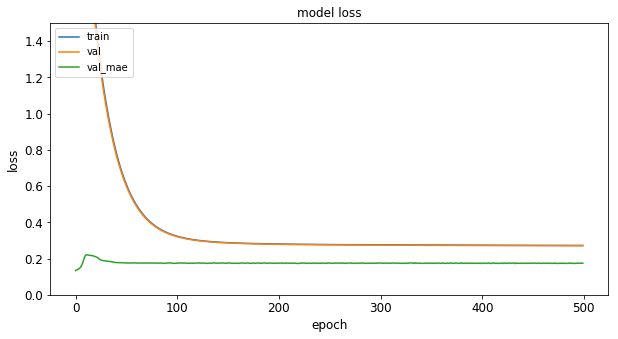

In [34]:
## Plot
print(history.history.keys())
plt.figure(figsize=(10,5))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.plot(history.history['val_mean_absolute_error'])
plt.title('model loss')
plt.ylabel('loss', fontsize=12)
plt.xlabel('epoch', fontsize=12)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.ylim([0, 1.5])
plt.legend(['train', 'val', 'val_mae'], loc='upper left')
plt.savefig('/data/imgs/mnist-autoencoder_%s_loss.png' % desc, dpi=150)

### Plot outputs

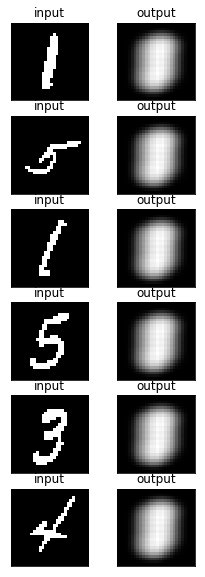

In [35]:
x_val_preds = model.predict(x_val)

examples = np.random.randint(0, high=x_val.shape[0], size=6)
fig, axs = plt.subplots(nrows=6, ncols=2, figsize=(3.5,10))
# fig.suptitle('Examples', fontsize=16)
for ynum in range(6):
    ax = axs[ynum, 0]
    ax.imshow(x_val[examples[ynum], :, :, 0], cmap='gray')
    ax.set_title('input', fontsize=12)
    ax.set_xticks([])
    ax.set_yticks([])
    ax = axs[ynum, 1]
    ax.imshow(x_val_preds[examples[ynum], :, :, 0], cmap='gray')
    ax.set_title('output', fontsize=12)
    ax.set_xticks([])
    ax.set_yticks([])
plt.savefig('/data/imgs/mnist-autoencoder_%s_in_out.png' % desc, dpi=150)

In [ ]:
x_val_preds = model.predict(x_val)

examples = np.random.randint(0, high=x_val.shape[0], size=12)
fig, axs = plt.subplots(nrows=12, ncols=2, figsize=(3.5,15))
# fig.suptitle('Examples', fontsize=16)
for ynum in range(12):
    ax = axs[ynum, 0]
    ax.imshow(x_val[examples[ynum], :, :, 0], cmap='gray')
    ax.set_title('input', fontsize=12)
    ax.set_xticks([])
    ax.set_yticks([])
    ax = axs[ynum, 1]
    ax.imshow(x_val_preds[examples[ynum], :, :, 0], cmap='gray')
    ax.set_title('output', fontsize=12)
    ax.set_xticks([])
    ax.set_yticks([])


## Look at weights of dense layer

In [ ]:
layer_name = 'Dense_7'
intermediate_layer_model = Model(inputs=model.input,
                                 outputs=model.get_layer(layer_name).output)
intermediate_output = intermediate_layer_model.predict(x_val)
print(intermediate_output.shape)

do_pca = True

if do_pca:
    ## Run PCA and select the top 50 bands
    pca = PCA(n_components=50)
    trans_data = pca.fit_transform(intermediate_output)
    print(pca.explained_variance_ratio_[:2]) 
else:
    trans_data = intermediate_output
    print(trans_data.shape)

In [ ]:
## Run t-sne and save output
x_embedded = TSNE().fit_transform(trans_data)
plt.figure()
print(x_embedded.shape)
plt.scatter(x_embedded[:, 0], x_embedded[:, 1], c=y_val, cmap='tab10')
plt.xticks([])
plt.yticks([])
plt.colorbar()
plt.savefig('/data/imgs/mnist-autoencoder_%s_tsne.png' % desc, dpi=150)

In [ ]:
## Apply kmeans
km_raw = KMeans(n_clusters=10).fit_predict(trans_data)
# km_raw = KMeans(n_clusters=10).fit_predict(x_embedded)
cm = confusion_matrix(y_val, km_raw)
# Create new labels, set all equal to 10
km_labels = np.ones(km_raw.shape, dtype=np.int8) * 10

Examine some groups for manual labelling

In [ ]:
raw_id = 9
examples = np.argwhere(km_raw==raw_id).squeeze()
print(examples.shape)
print(examples[:10])
# Get sixteen training examples
examples = np.random.permutation(examples)[:36]
fig, axs = plt.subplots(nrows=6, ncols=6, figsize=(10,10))
# fig.subplots_adjust(bottom=0.17, hspace=0.2)
# fig.suptitle('Cluster', fontsize=16)
for ynum in range(6):
    for xnum in range(6):
        indexnum = 6 * ynum + xnum
        ax = axs[xnum, ynum]
        ax.imshow(x_train[examples[indexnum], :, :, 0], cmap='gray')
#         ax.set_title('y = %i' % y_train[examples[indexnum]], fontsize=14)
        ax.set_xticks([])
        ax.set_yticks([])
plt.savefig('/data/imgs/mnist-cluster_%i.png' % raw_id, dpi=200)

mapping={0:10, }

In [ ]:
## Calculate true km_label
used = [False] * 10

def assign_val(argorder, used, km_labels, km_raw):
    for val in argorder:
        if used[val] == False:
            used[val] = True
            print('True val:', true_val, 'k-means label:', val)
            km_labels[km_raw==val] = true_val
            return(used, km_labels, km_raw)
            
for true_val in range(10):
    thisrow = cm[true_val, :]
    argorder = np.argsort(-thisrow)
    used, km_labels, km_raw = assign_val(argorder, used, km_labels, km_raw)
    
## Get confusion matrix and classification report

In [ ]:
print(confusion_matrix(y_val, km_labels))
print(classification_report(y_val, km_labels, digits=4))